# **Capstone Project - HerbPlant**

## Import Library

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import random
import shutil
import pathlib
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image

## Dataset

### Load Dataset

In [3]:
!wget https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip

--2025-06-11 15:28:14--  https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip [following]
--2025-06-11 15:28:14--  https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94022454 (90M) [application/zip]
Saving to: ‘Indonesia Medicinal Plant Dataset.zip’

Indonesia Medicinal 100%[===================>]  89.67M   176MB/s 

In [4]:
!mkdir -p "dataset/Indonesia Medicinal Plant Dataset"
!unzip -q "Indonesia Medicinal Plant Dataset.zip" -d "dataset/Indonesia Medicinal Plant Dataset"

In [5]:
base_path = "dataset/Indonesia Medicinal Plant Dataset"

image_paths = []
labels = []

for label in os.listdir(base_path):
    label_folder = os.path.join(base_path, label)
    if os.path.isdir(label_folder):
        for file_name in os.listdir(label_folder):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_folder, file_name))
                labels.append(label)

In [6]:
df = pd.DataFrame({
    'image': image_paths,
    'label': labels
})

df.head()

image  \
0  dataset/Indonesia Medicinal Plant Dataset/Euph...   
1  dataset/Indonesia Medicinal Plant Dataset/Euph...   
2  dataset/Indonesia Medicinal Plant Dataset/Euph...   
3  dataset/Indonesia Medicinal Plant Dataset/Euph...   
4  dataset/Indonesia Medicinal Plant Dataset/Euph...   

                                label  
0  Euphorbia Tirucalli (Patah Tulang)  
1  Euphorbia Tirucalli (Patah Tulang)  
2  Euphorbia Tirucalli (Patah Tulang)  
3  Euphorbia Tirucalli (Patah Tulang)  
4  Euphorbia Tirucalli (Patah Tulang)

In [7]:
class_counts = df['label'].value_counts()
print(class_counts)

label
Euphorbia Tirucalli (Patah Tulang)      100
Nepeta Cataria (Catnip)                 100
Artocarpus Integer (Nangka Cempedak)    100
Jasminum Sambac (Melati)                100
Caladium Cicolor (Keladi)               100
                                       ... 
Plectranthus Scutellarioides (Miana)    100
Pluchea Indica (Beluntas)               100
Physalis Angulata (Ceplukan)            100
Melaleuca Leucadendra (Kayu Putih)      100
Prunus Domestica (Plum)                 100
Name: count, Length: 100, dtype: int64


In [8]:
df['label'].unique()

array(['Euphorbia Tirucalli (Patah Tulang)', 'Nepeta Cataria (Catnip)',
       'Artocarpus Integer (Nangka Cempedak)', 'Jasminum Sambac (Melati)',
       'Caladium Cicolor (Keladi)', 'Melia Azedarach (Mindi)',
       'Hydrocotyle Sibthorpioides (Semanggi Gunung)',
       'Ruta Angustifolia (Inggu)', 'Raulvolvia Serpentina (Pule Pandak)',
       'Eupatorium Triplinerve (Prasman)', 'Centella Asiatica (Pegagan)',
       'Orthosiphon Spicatus (Kumis Kucing)',
       'Ocimum Basilicum (Kemangi)', 'Annona Muricata (Sirsak)',
       'Phytolacca Americana (Mrico Kepyar)',
       'Morinda Citrifolia (Mengkudu)', 'Peperomia Pellucida (Suruhan)',
       'Michelia Alba (Kembang Kantil)', 'Jatropa Multifida (Betadin)',
       'Pleomele Angustifolia (Suji)', 'Kaempferia Galanga (Kencur)',
       'Cymbopogon Nardus (Serai)',
       'Tithonia Diversifolia (Daun Insulin)',
       'Borreria Hispida (Gempur Batu)', 'Pouteria Caimito (Abiu)',
       'Ocimum Americanum (Selasih)', 'Curcuma Domestica (Kunyi

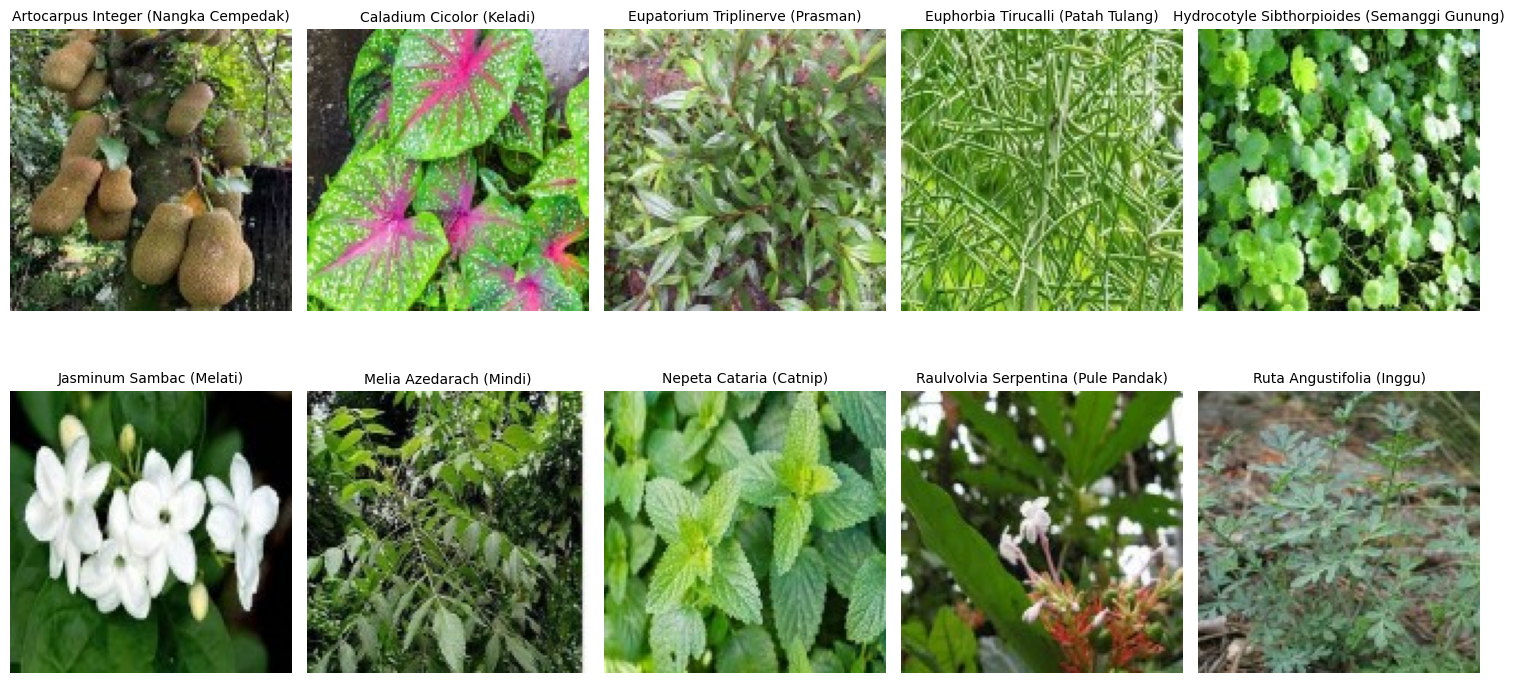

In [9]:
sampled_classes = df['label'].unique()[:10]
sampled_df = df[df['label'].isin(sampled_classes)].groupby('label').first().reset_index()

plt.figure(figsize=(15, 8))

for idx, row in sampled_df.iterrows():
    img = Image.open(row['image'])

    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(row['label'], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

### Split Dataset

In [10]:
train_df, val_test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
val_df, test_df = train_test_split(val_test_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [11]:
print('Data Training Shape    : ', len(train_df))
print('Data Validation Shape  : ', len(val_df))
print('Data Testing Shape     : ', len(test_df))

Data Training Shape    :  8000
Data Validation Shape  :  1000
Data Testing Shape     :  1000


### Data Augmentation

In [12]:
batch_size = 32
img_height = 224
img_width = 224

In [13]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.


In [14]:
data_augmentation = Sequential([
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal_and_vertical")
])

## Modelling

In [15]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

In [17]:
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [18]:
model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,
    pre_trained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,620 (9.96 MB)

 Trainable params: 1,239,716 (4.73 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

In [20]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = [
    EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
]

In [22]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_datagen),
    epochs=100,
    validation_data=val_datagen,
    validation_steps=len(val_datagen),
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.0831 - loss: 4.3209 - val_accuracy: 0.2580 - val_loss: 3.2472 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.3981 - loss: 2.5635 - val_accuracy: 0.3710 - val_loss: 2.5897 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5419 - loss: 1.8064 - val_accuracy: 0.4680 - val_loss: 2.1521 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6312 - loss: 1.4457 - val_accuracy: 0.5310 - val_loss: 1.7815 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6844 - loss: 1.1817 - val_accuracy: 0.5370 - val_loss: 1.7420 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.7483 - loss: 0.9863 - val_accuracy: 0.6270 - val_loss: 1.3671 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 8

In [23]:
import json

# Simpan class_indices ke file JSON
with open("class_indices.json", "w") as f:
    json.dump(train_datagen.class_indices, f)

# tampilkan hasil mapping
print("Label mapping disimpan sebagai class_indices.json:")
print(train_datagen.class_indices)

Label mapping disimpan sebagai class_indices.json:
{'Abelmoschus Esculentus (Okra)': 0, 'Acorus Calamus (Dlingo)': 1, 'Aloe Vera (Lidah Buaya)': 2, 'Alstonia Scholaris (Pulai)': 3, 'Amaranthus Spinosus (Bayam Duri)': 4, 'Andrographis Paniculata (Sambiloto)': 5, 'Annona Muricata (Sirsak)': 6, 'Annona Squamosa (Srikaya)': 7, 'Anredera Cordifolia (Binahong)': 8, 'Apium Graveolens (Seledri)': 9, 'Artocarpus Heterophyllus (Nangka Mini)': 10, 'Artocarpus Integer (Nangka Cempedak)': 11, 'Averrhoa Bilimbi (Belimbing Wuluh)': 12, 'Blumea Balsamifera (Sembung)': 13, 'Borreria Hispida (Gempur Batu)': 14, 'Caesalpinia Sappan L (Secang)': 15, 'Caladium Cicolor (Keladi)': 16, 'Calendula Officinalis (Marigold)': 17, 'Canangium Odoratum (Kenanga)': 18, 'Catharanthus Roseus (Tapak Dara)': 19, 'Celosia Cristata (Jengger Ayam)': 20, 'Centella Asiatica (Pegagan)': 21, 'Cestrum Nocturnum (Sedap Malam)': 22, 'Chrysopogon Zizanioides (Akar Wangi)': 23, 'Citrus Amblycarpa (Jeruk Limau)': 24, 'Clinalanthus Nut

## Evaluation

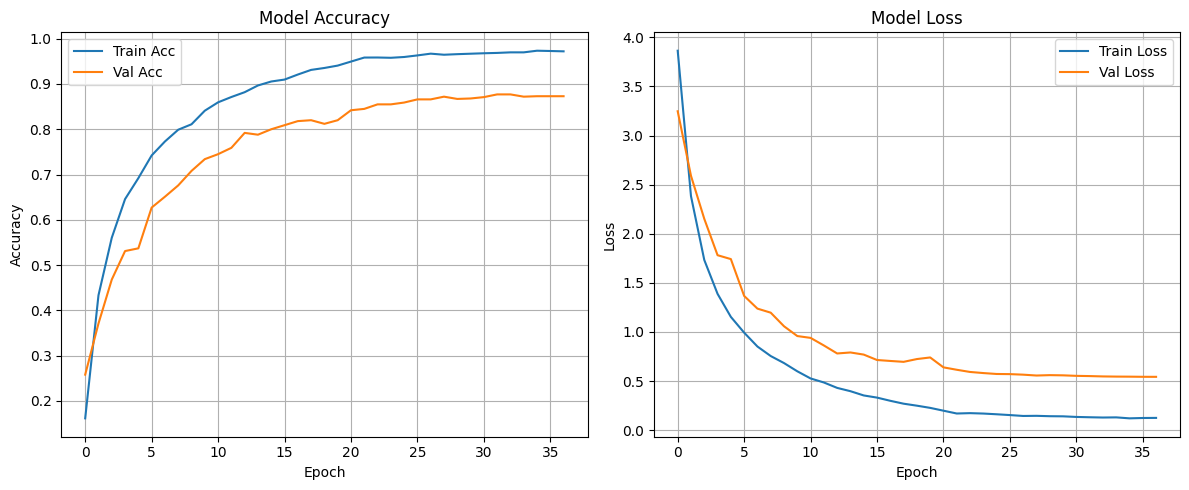

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Akurasi
axs[0].plot(history.history['accuracy'], label='Train Acc')
axs[0].plot(history.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()


In [25]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=0)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Test Loss     : 0.5424
Test Accuracy : 0.8700


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


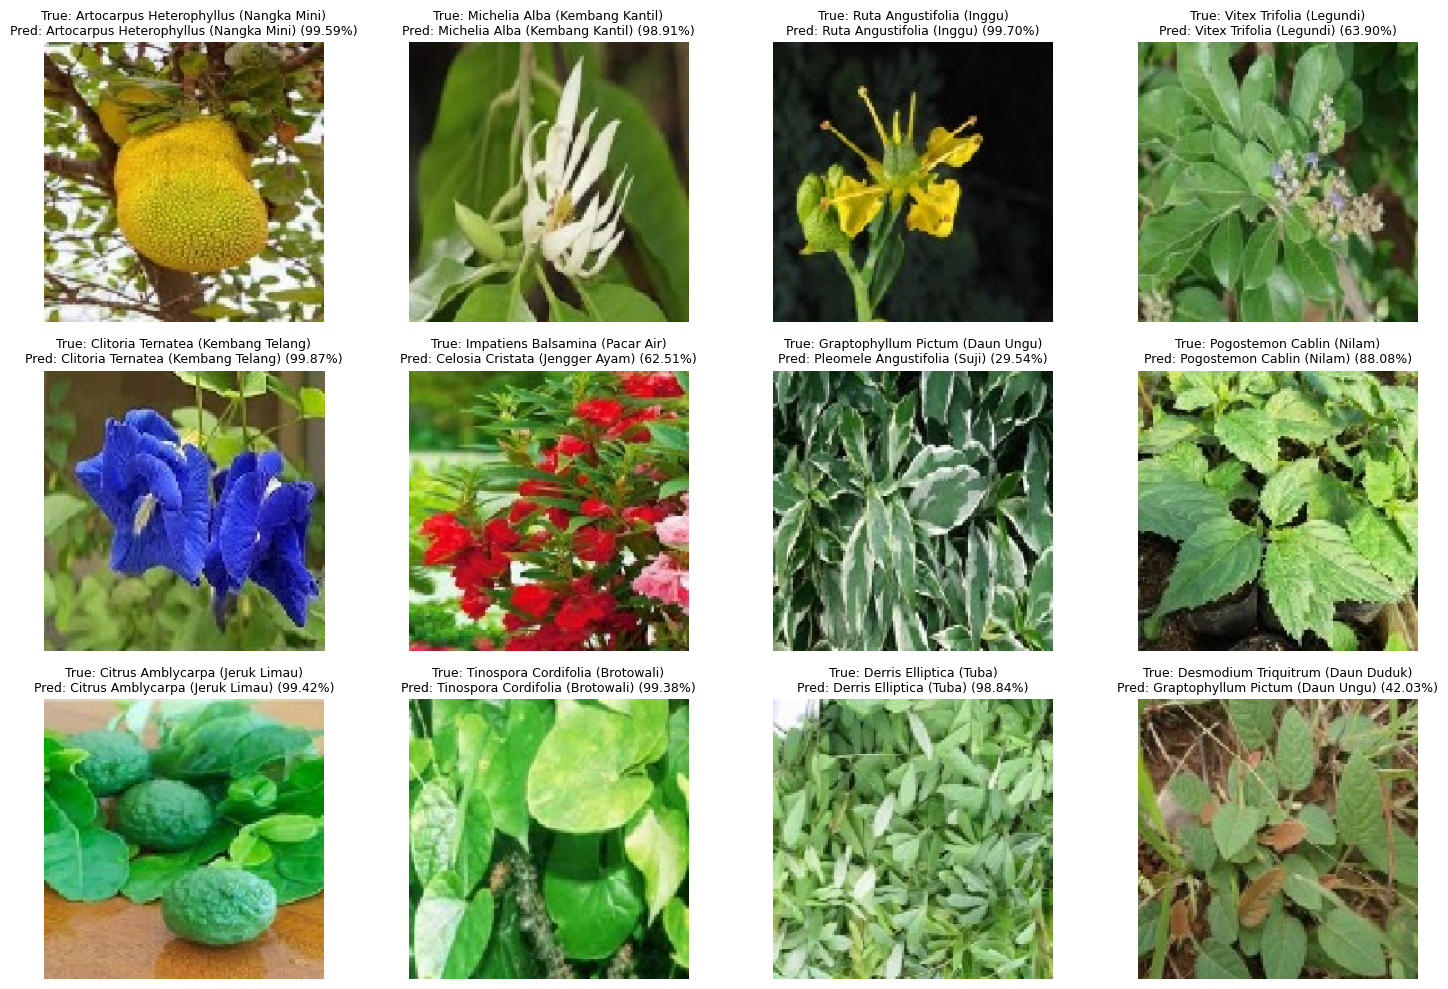

In [26]:
class_labels = list(test_datagen.class_indices.keys())

# Jumlah gambar yang ingin ditampilkan
num_images = 12
num_images_per_row = 4
num_rows = num_images // num_images_per_row

# Ambil satu batch dari test_datagen
images, labels = next(test_datagen)

# Lakukan prediksi
predictions = model.predict(images)

# Tampilkan hasil
plt.figure(figsize=(15, 10))
for i in range(num_images):
    predicted_index = np.argmax(predictions[i])
    predicted_class = class_labels[predicted_index]
    confidence = predictions[i][predicted_index] * 100  # jadi persen
    true_class = class_labels[np.argmax(labels[i])]

    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f}%)", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

Saving images (1).jpeg to images (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


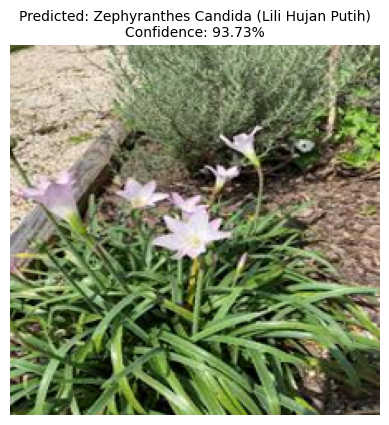

In [27]:
# Upload gambar
from google.colab import files
import io
uploaded = files.upload()

for file_binary in uploaded.values():
    img = Image.open(io.BytesIO(file_binary)).convert('RGB')
    img = img.resize((224, 224))

    # Preprocess
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Tampilkan
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
    plt.axis('off')
    plt.show()

## Konversi Model

In [28]:
model.build((None, 224, 224, 3))
model.save('/content/Model/model.h5')

!tensorflowjs_converter --input_format=keras /content/Model/model.h5 /content/Model/tfjs_model

# Unduh file .h5
from google.colab import files
files.download('/content/Model/model.h5')

# Zip model TF.js dan download
!zip -r tfjs_model.zip /content/Model/tfjs_model
files.download('tfjs_model.zip')


2025-06-11 15:44:58.673430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749656698.698645    6520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749656698.705500    6520 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Model/tfjs_model/ (stored 0%)
  adding: content/Model/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/model.json (deflated 96%)
  adding: content/Model/tfjs_model/group1-shard1of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
!pip freeze > requirements.txt

In [30]:
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>